# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

In [1]:
##run this cell to use the notebook

##it imports the modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.stats as ss
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np
import math as m
from math import pi


#and defines important methods

def f2plot(file,cat,pts):
    #this function takes a file and turns it into a
    #given matrix for plotting reasons
    table=np.zeros([cat,pts])
    lines=file.readlines()
    c=0
    for line in lines:
        line = line.replace("\n","")
        data = line.split(' ')
        for i in range(len(data)):
            table[i][c] = float(data[i])
        c += 1
    file.close()
    return table

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Overview 

In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

### Linear fit

We start by considering the very simple case:
$$
f(x)=2x+1
$$

Let's start defining the parameters of an ideal linear function which we are going to predict through a neural network regression

In [2]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise (that actually is set to zero):

In [3]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

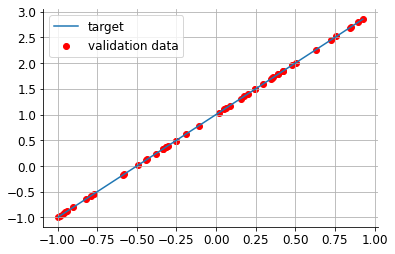

In [4]:
# plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

If you remember how a single node of a neural network works, you can easily spot that **just a single neuron can make the job**. So let's start using a simple Sequential model with just one layer on one neuron only!

In [5]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

2022-06-25 11:29:02.031684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 11:29:02.031754: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-25 11:29:05.061622: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-25 11:29:05.061652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spanakulis): /proc/driver/nvidia/version does not exist
2022-06-25 11:29:05.062277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA

In [6]:
# get a summary of our composed model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [7]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          verbose=1,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 9ms/step - loss: 0.9443 - mse: 0.9443 - val_loss: 0.6341 - val_mse: 0.6341
Epoch 2/30
16/16 [==============================] - 0s 2ms/step - loss: 0.5503 - mse: 0.5503 - val_loss: 0.3739 - val_mse: 0.3739
Epoch 3/30
16/16 [==============================] - 0s 2ms/step - loss: 0.3340 - mse: 0.3340 - val_loss: 0.2288 - val_mse: 0.2288
Epoch 4/30
16/16 [==============================] - 0s 2ms/step - loss: 0.2109 - mse: 0.2109 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 5/30
16/16 [==============================] - 0s 2ms/step - loss: 0.1395 - mse: 0.1395 - val_loss: 0.0997 - val_mse: 0.0997
Epoch 6/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0965 - mse: 0.0965 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 7/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 8/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0513 - mse: 0.05

By looking at weights and biases we can see if the linear fit was successfull: $w_1$ represents the angular coefficient, $b$ the intercept.

In [8]:
# return weights and biases
model.get_weights()

[array([[1.9695706]], dtype=float32), array([0.9996404], dtype=float32)]

In [9]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 2ms/step - loss: 2.9435e-04 - mse: 2.9435e-04

Test loss: 0.0002943543076980859
Test accuracy: 0.0002943543076980859


In [10]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 2ms/step - loss: 2.9435e-04 - mse: 2.9435e-04

Test loss: 0.0002943543076980859
Test accuracy: 0.0002943543076980859


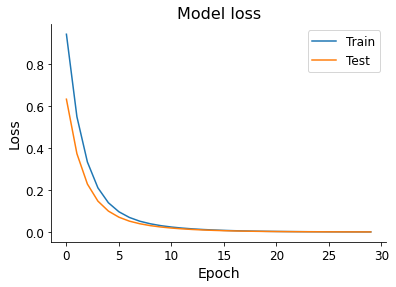

In [11]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

4/4 [==============================] - 0s 959us/step


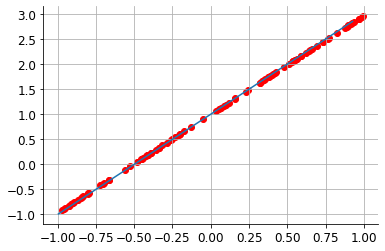

In [12]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Exercise 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

We start by taking the same identical model, but making it work for more epochs.

In [13]:
# generate training inputs
keras.backend.clear_session()
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=100,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))


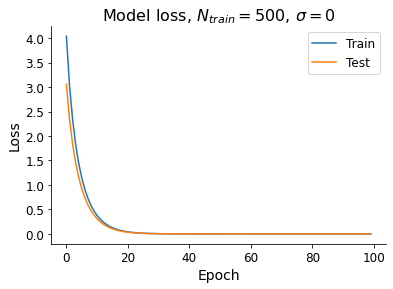

In [14]:
plt.title('Model loss, $N_{train}=500$, $\sigma=0$')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [15]:
# generate training inputs
keras.backend.clear_session()
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=100,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

In [16]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)
model2 = tf.keras.Sequential()
model2.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model2.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history2 = model2.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=100,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

In [17]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 100)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)
model3 = tf.keras.Sequential()
model3.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history3 = model3.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=100,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

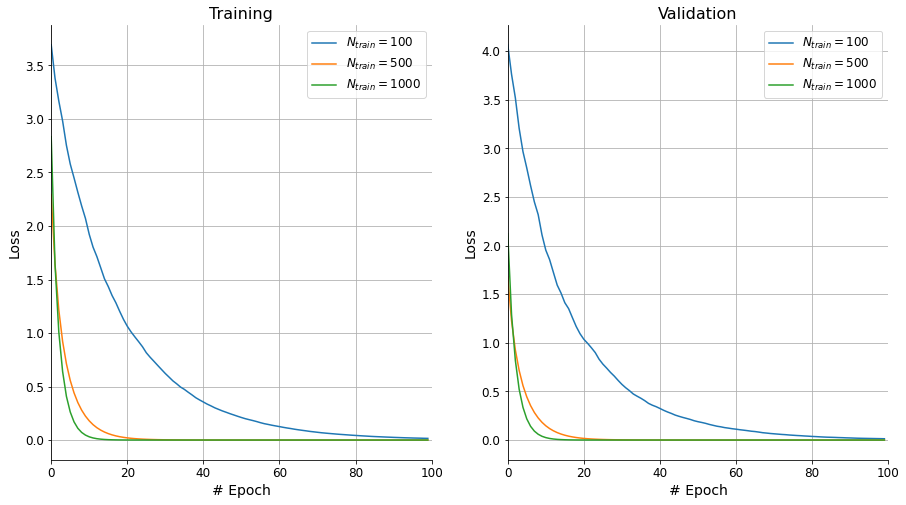

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].set_title("Training")
ax[1].set_title("Validation")
ax[0].set_xlim(0,100)
ax[1].set_xlim(0,100)

ax[0].plot(history3.history['loss'],label='$N_{train}=100$')
ax[1].plot(history3.history['val_loss'],label='$N_{train}=100$')


ax[0].plot(history.history['loss'],label='$N_{train}=500$')
ax[1].plot(history.history['val_loss'],label='$N_{train}=500$')

ax[0].plot(history2.history['loss'],label='$N_{train}=1000$')
ax[1].plot(history2.history['val_loss'],label='$N_{train}=1000$')



ax[0].set_xlabel('# Epoch')
ax[1].set_xlabel('# Epoch')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')


ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)

plt.show()

In the end, the error on both datasets tends to zero. This was expected, since we are just performing a linear fit on a linear flat function (no noise). We notice that increasing the size of dataset generally improves the quality of the fit.
Let's now consider the case where $\sigma \neq 0$

In [19]:
# generate training inputs
keras.backend.clear_session()
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 2. # noise standard deviation
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=300,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

In [20]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.5 # noise standard deviation
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)
model2 = tf.keras.Sequential()
model2.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model2.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history2 = model2.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=300,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

In [21]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 1. # noise standard deviation
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)
model3 = tf.keras.Sequential()
model3.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history3 = model3.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=300,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

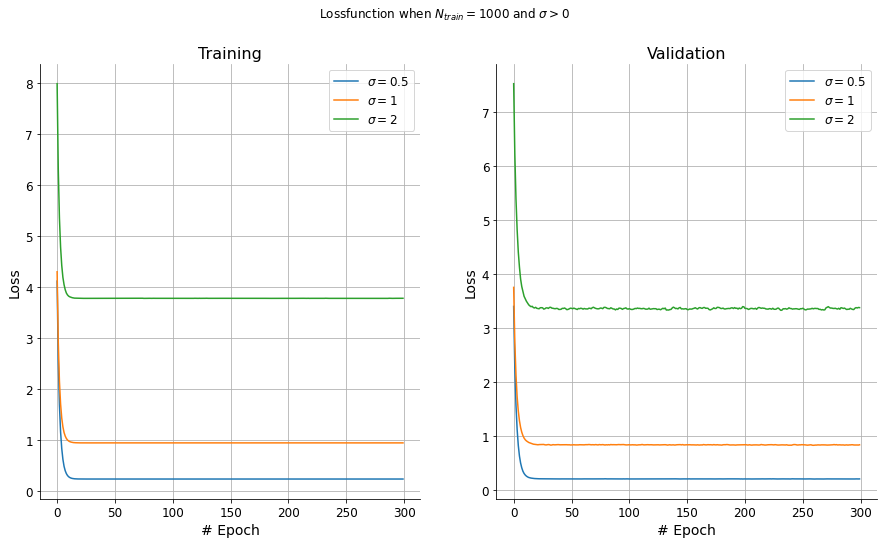

In [22]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
fig.suptitle("Lossfunction when $N_{train}=1000$ and $\sigma > 0$")
ax[0].set_title("Training")
ax[1].set_title("Validation")
#ax[0].set_xlim(0,100)
#ax[1].set_xlim(0,100)



ax[0].plot(history2.history['loss'],label='$\sigma=0.5$')
ax[1].plot(history2.history['val_loss'],label='$\sigma=0.5$')

ax[0].plot(history3.history['loss'],label='$\sigma=1$')
ax[1].plot(history3.history['val_loss'],label='$\sigma=1$')

ax[0].plot(history.history['loss'],label='$\sigma=2$')
ax[1].plot(history.history['val_loss'],label='$\sigma=2$')


ax[0].set_xlabel('# Epoch')
ax[1].set_xlabel('# Epoch')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')


ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)

plt.show()

In [23]:
mses=[]
sigmas = np.linspace(0,2.,num=10)
for s in sigmas:
    np.random.seed(0)
    x_train = np.random.uniform(-1, 1, 1000)
    x_valid = np.random.uniform(-1, 1, 50)
    x_valid.sort()
    y_target = m * x_valid + b # ideal (target) linear function
    y_train = np.random.normal(m * x_train + b, s) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(m * x_valid + b, s)
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
# compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    history = model.fit(x=x_train, y=y_train, 
    batch_size=32, epochs=150,
    verbose=0,
    shuffle=True, # a good idea is to shuffle input before at each epoch
    validation_data=(x_valid, y_valid))
    mses.append(np.mean(history.history['loss'][50:]))

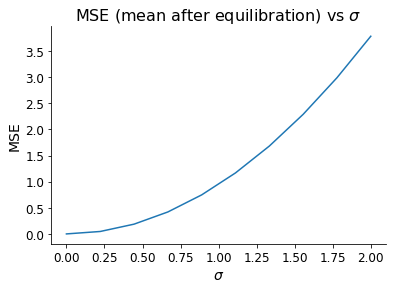

In [24]:
plt.plot(sigmas,mses)
plt.title('MSE (mean after equilibration) vs $\sigma$')
plt.ylabel('MSE')
plt.xlabel('$\sigma$')
plt.show()

We notice that we manage to fully fit the function, and only have some residual intrinsical error due to the structure of the target function.

### Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

In [143]:
keras.backend.clear_session()
#NN parameters
ntrain=1000
nval=100
xmin=-1
xmax=1
sigma=0.1

#define our data
def f(x):
    return 4 - 3*x - 2*(x**2) + 3*(x**3)
np.random.seed(0)

x_train=[]
x_val=[]
y_train=[]
y_val=[]

x_train=np.random.uniform(xmin,xmax,ntrain)
y_train= np.random.normal(f(x_train), sigma)


x_val=np.random.uniform(xmin,xmax,nval)
y_val= np.random.normal(f(x_val), sigma)


model2 = tf.keras.Sequential([
 (Dense(5, input_shape=(1,))),
 (Dense(9, activation='leaky_relu')),
    (Dense(9, activation='leaky_relu')),
    (Dense(4, activation='tanh')),
 (Dense(9, activation='leaky_relu')),
 (Dense(9, activation='leaky_relu')),
 (Dense(5,activation='leaky_relu')),
(Dense(1,activation='leaky_relu'))
])
model2.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
model2.summary()
history = model2.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=120,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_val, y_val))
score = model2.evaluate(x_val, y_val, batch_size=32, verbose=0)

xs=np.linspace(-1.5,1.5,2500)
ys=model2.predict(xs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 9)                 54        
                                                                 
 dense_2 (Dense)             (None, 9)                 90        
                                                                 
 dense_3 (Dense)             (None, 4)                 40        
                                                                 
 dense_4 (Dense)             (None, 9)                 45        
                                                                 
 dense_5 (Dense)             (None, 9)                 90        
                                                                 
 dense_6 (Dense)             (None, 5)                 5

The settings of the NN defined above seems to be good enough to fit the functions. They have been found after experimenting with different configurations.

We will also show that the prediction outside the training range will fail

Test loss: 0.027766847983002663
Test accuracy: 0.027766847983002663


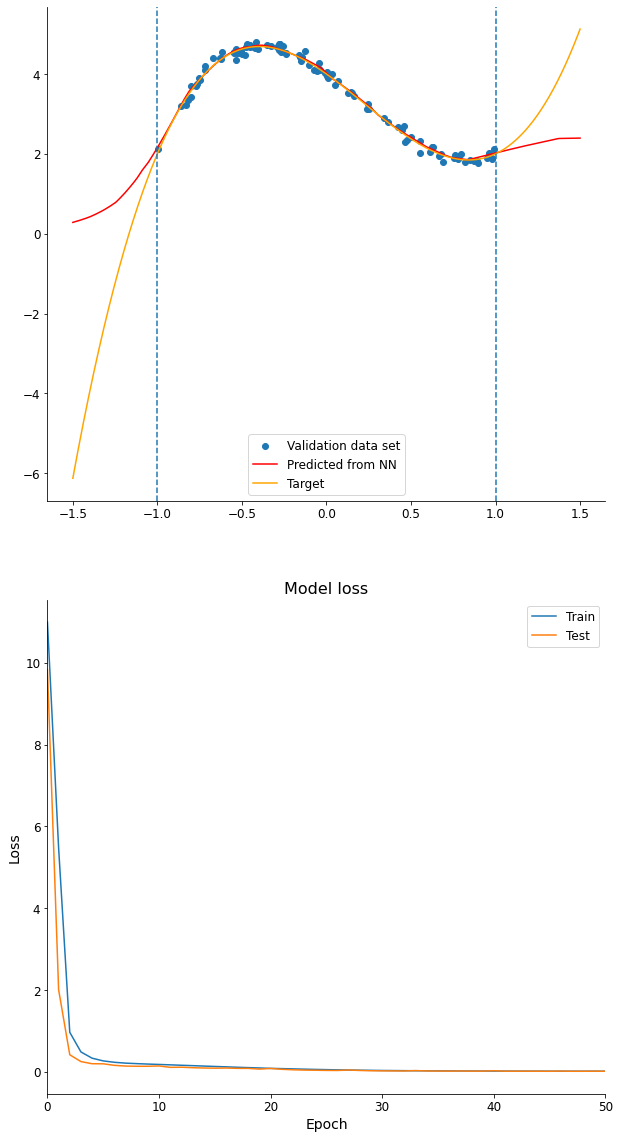

In [144]:
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
    # print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ysf=[]
for y in ys:
    ysf.append(y[0])
fig,ax=plt.subplots(2,1,figsize=(10,20))
ax[0].scatter(x_val,y_val,label='Validation data set')
ax[0].plot(xs,ysf,color='red',label='Predicted from NN')
ax[0].plot(xs,f(xs),label='Target',color='orange')
ax[0].axvline(-1.,linestyle='dashed')
ax[0].axvline(1.,linestyle='dashed')

ax[0].legend()


ax[1].set_title('Model loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim(0,50)
ax[1].legend(['Train', 'Test'], loc='best')

plt.show()

We have learned that the number of parameters (an index of the complexity of the NN) ought to be balanced with respect to the problem, that is, too many parameters expose to the risk of overfitting, or learning noise from the dataset. In this case, we will have a very low error on the training test, but will start to lose accuracy on other dataset from the same underlying distribution.

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [76]:
from mpl_toolkits.mplot3d import Axes3D

/tmp/ipykernel_10948/3811485301.py:39: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


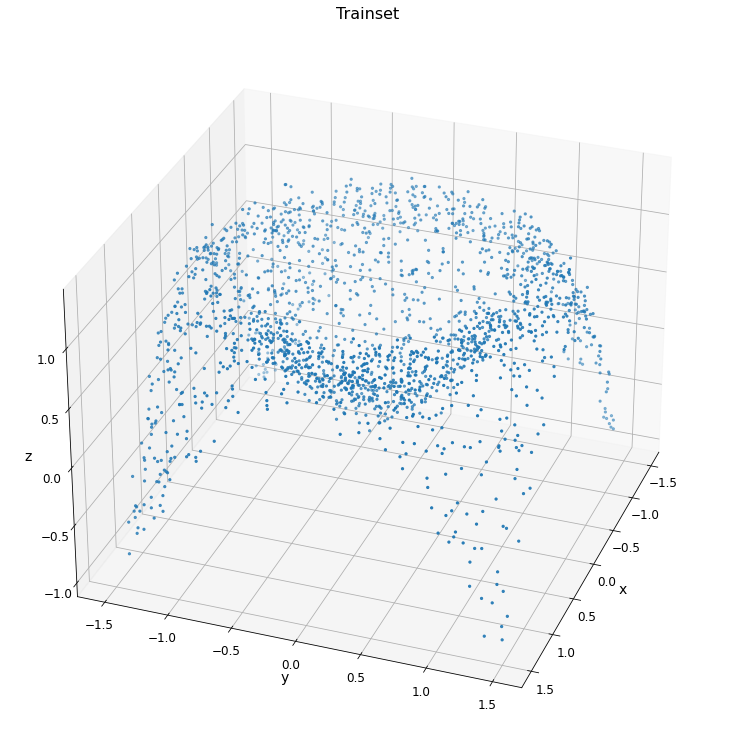

In [174]:

#NN parameters
ntrain=2000
nval=200
xmin=-1.5
xmax=1.5
sigma=0.1
x_train=[]
x_val=[]
y_train=[]
y_val=[]

#define our data
def f(x,y):
    return np.sin(x**2 + y**2)
np.random.seed(0)


x_train = np.zeros((ntrain, 2))
y_train = np.zeros((ntrain, 1))

x_val = np.zeros((nval, 2))
y_val = np.zeros((nval, 1))

for i in range(ntrain):
    x_train[i,0]=np.random.uniform(xmin, xmax)
    x_train[i,1]=np.random.uniform(xmin, xmax)
    y_train[i]= np.random.normal(np.sin(x_train[i,0]**2+x_train[i,1]**2),sigma)
for i in range(nval):
    x_val[i,0]=np.random.uniform(xmin, xmax)
    x_val[i,1]=np.random.uniform(xmin, xmax)
    y_val[i]= np.random.normal(np.sin(x_val[i,0]**2+x_val[i,1]**2),sigma)

M=ntrain

X=x_train[:,0]
Y=x_train[:,1]
Z=y_train
fig = plt.figure(figsize=(10,20))
ax = Axes3D(fig)
ax.scatter(X, Y, Z, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 20)
plt.title('Trainset')
plt.show()

In [175]:
keras.backend.clear_session()

model = tf.keras.Sequential([
  Dense(6,input_shape=(2,),activation='linear'),
  Dense(8,activation='leaky_relu'),
  Dense(8,activation='leaky_relu'),
  Dense(8,activation='leaky_relu'),
  Dense(10,activation='softplus'), 
    Dense(8,activation='leaky_relu'),
  Dense(8,activation='tanh'),
  Dense(6,activation='leaky_relu'),
  Dense(1, activation='leaky_relu')
])
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model.summary()
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=500,
          verbose=0,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_val, y_val))
score = model.evaluate(x_val, y_val, batch_size=32, verbose=0)
xs=np.random.uniform(-1.5,1.5,(5000,2))
ys=model.predict(xs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 18        
                                                                 
 dense_1 (Dense)             (None, 8)                 56        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
 dense_5 (Dense)             (None, 8)                 88        
                                                                 
 dense_6 (Dense)             (None, 8)                 7

[[ 1.27631178  1.17539713]
 [ 0.5413837   1.38308081]
 [-0.81311698 -1.4411933 ]
 ...
 [ 0.69691736  0.79012424]
 [-0.23640326 -0.77198911]
 [-0.69599595 -0.60923334]]


/tmp/ipykernel_10948/2009249341.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


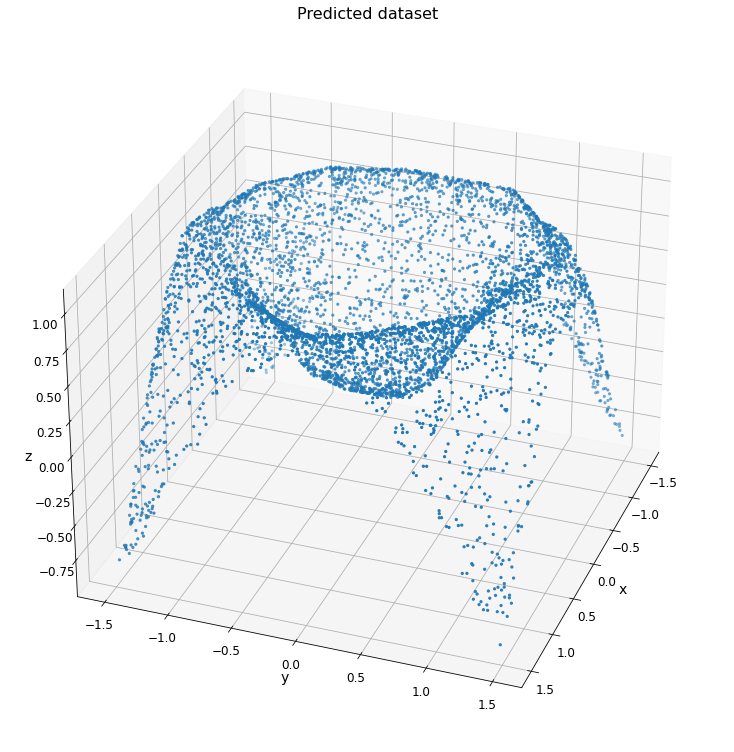

In [176]:
fig = plt.figure(figsize=(10,20))
print(xs)
X=xs[:,0]
Y=xs[:,1]
Z=ys
ax = Axes3D(fig)
ax.scatter(X, Y, Z, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 20)
plt.title('Predicted dataset')
plt.show()

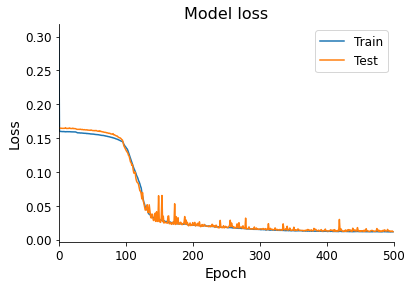

In [177]:
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0,500)
plt.legend(['Train', 'Test'], loc='best')

plt.show()

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>